# Построение моделей ElasticNet, XGboost, RandomForest с подобром гиперпараметров на скользящей кросс-валидации для прогнозирования российского экспорта и импорта 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns; sns.set(rc={'figure.figsize':(15,8)})
sns.set_palette(sns.color_palette('bright'))
import warnings 
warnings.simplefilter(action='ignore')

In [2]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.ensemble.forest import RandomForestRegressor

## Подгрузка данных

### Все ряды взяты в разностях логарифмов для стационраности

In [3]:
price_no_season = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\price_no_season.csv', sep = ";", index_col = 'Date')
price_no_season = price_no_season.diff(axis = 0, periods = 1).iloc[1:,:]
price_no_season.head()

,meat_im,cirtus_im,black_metal_im,chocolate_im,auto_im,motors_im,auto_ex,benz_ex,rubber_ex,cooper_ex,oil_ex,nikel_ex,steel_ex,minerals_ex,coal_ex,wood_ex,alloy_ex,black_metal_ex,adj_income
Date,,,,,,,,,,,,,,,,,,,
2005Q2,0.053723,-0.178112,-0.045075,0.265907,0.187711,0.208906,0.053691,-0.113874,0.000075,0.203830,0.113993,-0.044252,0.324534,0.049037,-0.363880,0.131285,-0.051261,0.141701,-0.000727
2005Q3,0.083920,-0.076535,0.770503,0.427578,-0.030955,0.088613,0.004609,0.112924,-0.017613,0.078779,-0.187744,0.085382,0.422845,0.075844,0.204691,0.160104,-0.013400,-0.029848,0.074896
2005Q4,-0.051899,0.156076,-0.881659,0.110082,0.287412,0.030758,0.021627,0.170678,0.014168,0.165394,-0.161313,0.075152,-0.448111,0.081225,-0.055375,-0.085257,-0.022906,-0.043274,0.024010
2006Q1,0.168637,0.208174,0.160454,0.331721,-0.015812,-0.029624,0.045675,-0.064800,0.212380,-0.505591,-0.021812,0.047505,0.975537,0.066445,-0.600846,0.084647,0.025532,0.150201,0.175281
2006Q2,0.042896,0.027545,0.816597,0.320720,0.140950,0.231105,0.025776,0.137525,-0.105337,0.189628,0.448328,0.070972,-0.391147,0.147734,0.691363,0.021312,-0.070838,0.061772,0.054324


In [4]:
price_fred = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\price_fred.csv', sep = ";")
price_bloomberg = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\price_bloomberg.csv', sep = ";")
price_fred = price_fred.set_index('Date')
price_bloomberg = price_bloomberg.set_index('Date')
price_bloomberg = price_bloomberg.iloc[::-1]
price_fred.head()

,chemical,machines,gas,oil,steel,wood,phapma,meat,petroleoum,chemical_2,lumber,nonferrous_metals,farm,electrical_machinery,machinery,inorganic
Date,,,,,,,,,,,,,,,,
15.01.2005,147.5,147.0,6.15,45.48,207.1,136.4,369.2,141.4,126.2,177.8,197.6,155.7,118.8,113.4,164.2,133.7
15.02.2005,147.1,148.9,6.14,53.10,206.9,138.3,370.5,145.0,133.0,179.2,205.5,157.6,117.6,113.4,165.9,134.5
15.03.2005,148.1,149.6,6.96,51.88,193.1,140.0,370.7,146.4,148.6,185.1,206.4,160.6,123.0,113.3,167.3,135.2
15.04.2005,148.7,149.4,7.16,48.65,193.3,138.6,372.1,144.8,155.3,184.2,204.8,161.6,120.7,113.3,167.9,136.4
15.05.2005,149.9,149.6,6.47,54.35,188.8,138.8,375.8,147.9,151.3,181.0,196.9,161.1,121.5,113.1,168.4,137.5


In [5]:
price_bloomberg = price_bloomberg.T.groupby(pd.PeriodIndex(price_bloomberg.T.columns, freq='Q'), axis=1).mean().round(2).T
price_bloomberg = price_bloomberg.drop([price_bloomberg.index[-1], price_bloomberg.index[-2]])
price_bloomberg = np.log(price_bloomberg).diff(axis = 0, periods = 1).iloc[1:,:]
price_bloomberg.tail()

,corn,copper,wheat,allum,gold
Date,,,,,
2018Q2,0.011520,-0.028278,0.102007,0.058476,-0.026970
2018Q3,-0.051693,-0.090301,0.028871,-0.076129,-0.068649
2018Q4,0.023130,-0.026639,-0.039828,-0.082965,0.027190
2019Q1,-0.008865,0.072082,-0.062989,-0.007085,0.055554
2019Q2,0.091992,-0.050088,0.015833,-0.065901,0.019262


In [6]:
price_fred = price_fred.T.groupby(pd.PeriodIndex(price_fred.T.columns, freq='Q'), axis=1).mean().round(2).T
price_fred = price_fred.drop(price_fred.index[-1])
price_fred = np.log(price_fred).diff(axis = 0, periods = 1).iloc[1:,:]
price_fred.head()

,chemical,machines,gas,oil,steel,wood,phapma,meat,petroleoum,chemical_2,lumber,nonferrous_metals,farm,electrical_machinery,machinery,inorganic
Date,,,,,,,,,,,,,,,,
2005Q2,0.013462,0.010050,0.077884,0.064850,-0.070841,0.004331,0.013605,0.006219,0.128054,0.001825,-0.009098,0.023770,0.003084,-0.002119,0.015382,0.024970
2005Q3,0.025480,0.027615,0.328619,0.144197,0.009345,-0.005272,0.023626,-0.031489,0.170766,0.035116,-0.023927,0.022191,-0.036439,-0.000531,0.006866,0.033031
2005Q4,0.036100,-0.006506,0.240421,-0.057434,0.123895,-0.002901,0.003015,0.009622,0.015700,0.088890,-0.015741,0.067783,0.019063,-0.003899,0.007463,0.057275
2006Q1,-0.009094,0.013164,-0.463824,0.095061,0.018855,0.027222,0.022251,-0.029727,-0.050341,0.006178,0.033889,0.082387,-0.040346,0.001774,0.009324,0.107942
2006Q2,-0.006364,0.024814,-0.164581,0.096330,0.024304,0.015219,0.010352,-0.005382,0.191664,0.032117,-0.014796,0.159784,-0.015996,0.017571,0.010788,0.025432


In [7]:
income = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\income.csv', sep = ";")
income = income.drop(income.index[-1])
income = income.iloc[:,1:]
income = np.log(income).diff(axis = 0, periods = 1).iloc[1:,:]
income = income.set_index(price_fred.index)
income = pd.concat([income, price_no_season['adj_income'].to_frame().set_index(income.index)], axis=1, join_axes = [income.index])
income = income.iloc[:,1:]
income.head()

,kurs,adj_income
Date,,
2005Q2,0.008584,-0.000727
2005Q3,0.015197,0.074896
2005Q4,0.006642,0.024010
2006Q1,-0.018995,0.175281
2006Q2,-0.034686,0.054324


In [8]:
col_names=list('Q')
for i in list(range(98)):
    col_names.append(str(i)+'_ex') 
    col_names.append(str(i)+'_im')
del col_names[154]
del col_names[154]
len(col_names)

195

In [9]:
data = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\export_all_not_sa.csv', sep = ";", names = col_names)
data = data.set_index('Q')
del data['50_ex']
data_no_season = pd.read_csv('C:\\Users\\Ksenia\\data_nir\\data_no_season.csv', sep = ",")
data_no_season = data_no_season.set_index('Q')
del data_no_season["Index"]
del col_names[0]
del col_names[101]
del col_names[101]
data_no_season.columns = col_names
data_no_season["97_im"] = np.log(data_no_season["97_im"])
data_no_season = data_no_season.diff(axis = 0, periods = 1).iloc[1:,:]
data_no_season["10_ex"] = np.log(data['10_ex']).diff()[1:]
data_no_season["13_ex"] = np.log(data['13_ex']).diff()[1:]
data_no_season["14_ex"] = np.log(data['14_ex']).diff()[1:]
data_no_season.head()

,0_ex,0_im,1_ex,1_im,2_ex,2_im,3_ex,3_im,4_ex,4_im,...,93_ex,93_im,94_ex,94_im,95_ex,95_im,96_ex,96_im,97_ex,97_im
Q,,,,,,,,,,,,,,,,,,,,,
2005Q2,0.053723,-0.178112,-0.045075,0.265907,0.187711,0.208906,0.053691,-0.113874,0.000075,0.203830,...,0.016843,-1.323616,-0.013545,0.168724,0.314178,0.042549,-0.175288,0.162527,2.032922,-0.005970
2005Q3,0.083920,-0.076535,0.770503,0.427578,-0.030955,0.088613,0.004609,0.112924,-0.017613,0.078779,...,-0.154934,0.446619,-0.030662,-0.008291,0.056634,-0.083803,-0.253988,0.049021,-1.156371,3.606539
2005Q4,-0.051899,0.156076,-0.881659,0.110082,0.287412,0.030758,0.021627,0.170678,0.014168,0.165394,...,0.130678,-0.771171,0.005979,0.113524,0.022171,0.154130,0.266592,0.082822,1.343500,-2.001301
2006Q1,0.168637,0.208174,0.160454,0.331721,-0.015812,-0.029624,0.045675,-0.064800,0.212380,-0.505591,...,-0.301768,-0.230165,0.192393,0.072913,0.369191,0.098389,-0.976225,0.083586,-1.338109,-1.376124
2006Q2,0.042896,0.027545,0.816597,0.320720,0.140950,0.231105,0.025776,0.137525,-0.105337,0.189628,...,0.374248,0.863879,0.059539,0.055564,-0.037073,0.114081,0.978530,0.052597,0.072571,-0.145852


In [10]:
all_data = pd.concat([data_no_season, 
                      income.set_index(data_no_season.index),
                      price_fred.set_index(data_no_season.index), 
                      price_bloomberg.set_index(data_no_season.index)], 
                      axis=1, join_axes=[data_no_season.index])

In [11]:
data_first_lag = all_data.iloc[:-1,:].set_index(all_data.iloc[1:,:].index)
data_first_lag.columns = all_data.columns + '_1_lag'
new = pd.concat([all_data,
                 data_first_lag],
                 axis=1, join_axes=[all_data.index])
new = new.iloc[1:,:]
new.head()

,0_ex,0_im,1_ex,1_im,2_ex,2_im,3_ex,3_im,4_ex,4_im,...,nonferrous_metals_1_lag,farm_1_lag,electrical_machinery_1_lag,machinery_1_lag,inorganic_1_lag,corn_1_lag,copper_1_lag,wheat_1_lag,allum_1_lag,gold_1_lag
Q,,,,,,,,,,,,,,,,,,,,,
2005Q3,0.083920,-0.076535,0.770503,0.427578,-0.030955,0.088613,0.004609,0.112924,-0.017613,0.078779,...,0.023770,0.003084,-0.002119,0.015382,0.024970,0.022937,0.014630,0.012432,-0.093441,0.001071
2005Q4,-0.051899,0.156076,-0.881659,0.110082,0.287412,0.030758,0.021627,0.170678,0.014168,0.165394,...,0.022191,-0.036439,-0.000531,0.006866,0.033031,0.007018,0.118005,0.004377,0.046839,0.033943
2006Q1,0.168637,0.208174,0.160454,0.331721,-0.015812,-0.029624,0.045675,-0.064800,0.212380,-0.505591,...,0.067783,0.019063,-0.003899,0.007463,0.057275,-0.070843,0.156938,-0.015777,0.152560,0.104130
2006Q2,0.042896,0.027545,0.816597,0.320720,0.140950,0.231105,0.025776,0.137525,-0.105337,0.189628,...,0.082387,-0.040346,0.001774,0.009324,0.107942,0.130035,0.148481,0.100019,0.133636,0.147974
2006Q3,0.042127,0.074761,-1.140702,0.339723,0.083959,0.191444,0.081432,0.099005,0.182103,0.053435,...,0.159784,-0.015996,0.017571,0.010788,0.025432,0.060071,0.415751,0.046047,0.081392,0.108385


In [29]:
X = new.iloc[:,192:]
y = new.iloc[:,1]
X_train = X.iloc[:38,:]
X_test = X.iloc[38:,:]
y_train = y[:38]
y_test = y[38:]

## ElasticNet

In [13]:
model=make_pipeline(StandardScaler(), 
                    ElasticNet() 
                         )
pipe = Pipeline([('preprocessing', StandardScaler()),
                 ('regresion', ElasticNet(tol=0.0001,max_iter = 10000))])

cv=TimeSeriesSplit(n_splits=5)
param_grid =[
    {'regresion__l1_ratio': [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
     'regresion__alpha': [num / 100000 for num in range(100, 50000, 100)]
     }
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, iid=True, scoring = 'neg_mean_squared_error')
grid.fit(X_train,y_train)

print("Параметры лучшего решения:\n{}\n".format(grid.best_params_))
print("Осредненный score для наилучшей модели кроссвалидации на проверочных тренировочных наборах: {:.6f}\n".format(grid.best_score_))
print("Score на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

Параметры лучшего решения:
{'regresion__alpha': 0.005, 'regresion__l1_ratio': 0}

Осредненный score для наилучшей модели кроссвалидации на проверочных тренировочных наборах: -0.006305

Score на тестовом наборе: -0.00


,28,63,98,56,140,133,105,91,217,259,...,517,551,572,732,725,496,510,565,558,503
mean_fit_time,0.39654,0.333508,0.287836,0.334312,0.322154,0.297611,0.303195,0.310369,0.389984,0.354573,...,0.0041882,0.00398955,0.00378962,0.00418887,0.00458784,0.00438843,0.00438809,0.0035903,0.00379014,0.00358973
std_fit_time,0.0372188,0.0379172,0.0212678,0.0549818,0.0259268,0.00405948,0.0127378,0.00739391,0.0665513,0.0212763,...,0.00074606,7.4789e-07,0.00116315,0.0007462,0.000797725,0.00101708,0.000488909,0.000488578,0.000398994,0.00048889
mean_score_time,0.00139685,0.00219445,0.00159736,0.00159259,0.00159483,0.00159721,0.00139556,0.00139771,0.00159698,0.00139642,...,0.000997448,0.000997257,0.00159602,0.00159574,0.00199423,0.00119658,0.00139685,0.00119681,0.00139637,0.00119762
std_score_time,0.000488656,0.00074545,0.00048887,0.000803177,0.000487405,0.000490897,0.000482838,0.00048815,0.000488364,0.000488909,...,2.4314e-07,2.78041e-07,0.000488656,0.000488422,0.000629771,0.000398779,0.000489338,0.000399017,0.00048885,0.00039897
param_regresion__alpha,0.005,0.01,0.015,0.009,0.021,0.02,0.016,0.014,0.032,0.038,...,0.074,0.079,0.082,0.105,0.104,0.071,0.073,0.081,0.08,0.072
param_regresion__l1_ratio,0,0,0,0,0,0,0,0,0,0,...,1,0.9,0.9,0.7,0.7,1,1,0.9,0.9,1
params,"{'regresion__alpha': 0.005, 'regresion__l1_rat...","{'regresion__alpha': 0.01, 'regresion__l1_rati...","{'regresion__alpha': 0.015, 'regresion__l1_rat...","{'regresion__alpha': 0.009, 'regresion__l1_rat...","{'regresion__alpha': 0.021, 'regresion__l1_rat...","{'regresion__alpha': 0.02, 'regresion__l1_rati...","{'regresion__alpha': 0.016, 'regresion__l1_rat...","{'regresion__alpha': 0.014, 'regresion__l1_rat...","{'regresion__alpha': 0.032, 'regresion__l1_rat...","{'regresion__alpha': 0.038, 'regresion__l1_rat...",...,"{'regresion__alpha': 0.074, 'regresion__l1_rat...","{'regresion__alpha': 0.079, 'regresion__l1_rat...","{'regresion__alpha': 0.082, 'regresion__l1_rat...","{'regresion__alpha': 0.105, 'regresion__l1_rat...","{'regresion__alpha': 0.104, 'regresion__l1_rat...","{'regresion__alpha': 0.071, 'regresion__l1_rat...","{'regresion__alpha': 0.073, 'regresion__l1_rat...","{'regresion__alpha': 0.081, 'regresion__l1_rat...","{'regresion__alpha': 0.08, 'regresion__l1_rati...","{'regresion__alpha': 0.072, 'regresion__l1_rat..."
split0_test_score,-0.0127588,-0.0131381,-0.0136706,-0.0135506,-0.013729,-0.0135837,-0.0137405,-0.0132286,-0.0136157,-0.0135726,...,-0.0161916,-0.0162017,-0.0161916,-0.0161916,-0.0161916,-0.016203,-0.0161916,-0.0161916,-0.016193,-0.016193
split1_test_score,-0.011262,-0.0107584,-0.0108108,-0.0116033,-0.0108761,-0.0109069,-0.0109529,-0.0109517,-0.0108838,-0.0108885,...,-0.0321772,-0.032264,-0.0321909,-0.032196,-0.0322836,-0.0323755,-0.0323057,-0.0323061,-0.0324269,-0.0324411
split2_test_score,-0.00581188,-0.00792682,-0.00781508,-0.00749777,-0.0081814,-0.00870939,-0.00823138,-0.00919128,-0.00863391,-0.00877881,...,-0.0036842,-0.00361033,-0.00367961,-0.00367382,-0.00365512,-0.00360784,-0.00365798,-0.0036559,-0.00363281,-0.00363252


## Псевдореальный прогноз российского экспорта и иморта, построенный ElasticNet

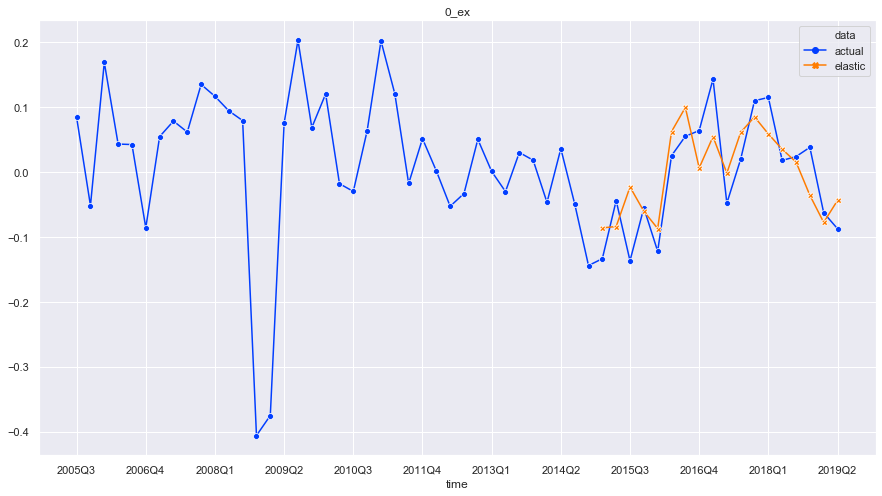

In [183]:
predicted = [0]*56
predicted[38:] = best_model.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()

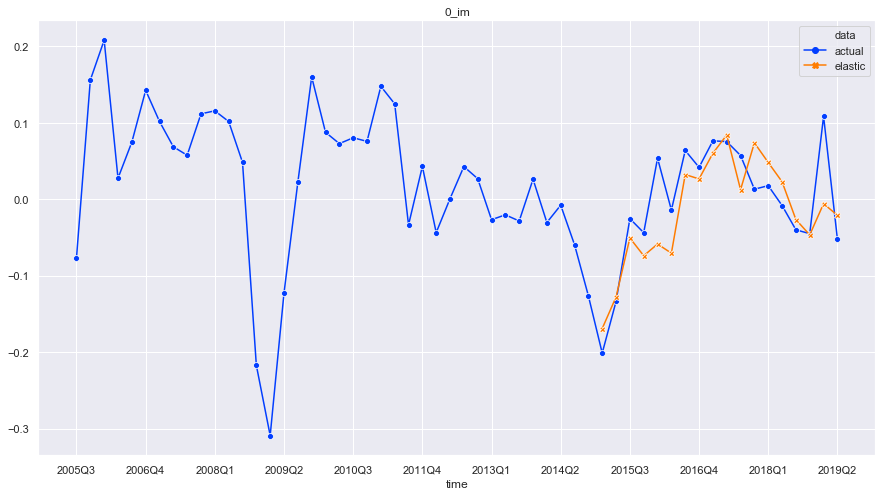

In [591]:
predicted = [0]*56
predicted[38:] = best_model.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()

## XGBoost

In [23]:
model=make_pipeline(xgb.XGBRegressor())
pipe = Pipeline([('regresion', xgb.XGBRegressor(objective ='reg:squarederror', bootstrap=False))])

cv=TimeSeriesSplit(n_splits=5)
param_grid =[
    {'regresion__n_estimators' : [5, 20, 50, 100, 200, 500, 1000],
     'regresion__base_score' : [0.1, 0.2, 0.3],
     'regresion__reg_alpha' : [0.0005, 0.001, 0.005, 0.01, 0.1],
     'regresion__colsample_bytree' : [0.1, 0.2, 0.3, 0.4]
     }
]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, iid=True, scoring = 'neg_mean_squared_error')
grid.fit(X_train,y_train)

print("Параметры лучшей модели:\n{}\n".format(grid.best_params_))
print("Средняя метрика на тестовых наборах: {:.6f}\n".format(grid.best_score_))
print("Метрика на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

Параметры лучшей модели:
{'regresion__base_score': 0.3, 'regresion__colsample_bytree': 0.1, 'regresion__n_estimators': 200, 'regresion__reg_alpha': 0.0005}

Средняя метрика на тестовых наборах: -0.012701

Метрика на тестовом наборе: -0.00


,305,300,310,295,301,311,306,296,127,137,...,280,282,283,319,284,318,352,354,353,389
mean_fit_time,0.29222,0.12845,0.557308,0.0758025,0.126658,0.603546,0.28384,0.0705982,0.175929,0.743405,...,0.0105556,0.00956483,0.0101696,0.0131639,0.00977325,0.0129636,0.0109613,0.0107563,0.0107702,0.0109616
std_fit_time,0.0262213,0.0108095,0.0322096,0.00869921,0.0157405,0.03013,0.0162246,0.00862612,0.0265272,0.109489,...,0.00101688,0.000495916,0.000980339,0.001934,0.000746545,0.00166818,0.000898949,0.00196218,0.00116371,0.000618527
mean_score_time,0.0045855,0.00458798,0.00519509,0.00637755,0.00539384,0.00638356,0.00478802,0.0059978,0.00479431,0.00558524,...,0.0055934,0.00459704,0.00459461,0.00618367,0.00539441,0.0109721,0.00498843,0.00558467,0.00519562,0.00498734
std_score_time,0.000797281,0.000488208,0.000976304,0.00185342,0.000803005,0.00149289,0.000746633,0.00166098,0.000402735,0.00079813,...,0.000479778,0.000507629,0.000479353,0.00146604,0.000481947,0.0010941,0.0010918,0.000489303,0.00075308,0.000631053
param_regresion__base_score,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.1,0.1,...,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3
param_regresion__colsample_bytree,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.4,0.4,...,0.1,0.1,0.1,0.2,0.1,0.2,0.3,0.3,0.3,0.4
param_regresion__n_estimators,500,200,1000,100,200,1000,500,100,200,1000,...,5,5,5,5,5,5,5,5,5,5
param_regresion__reg_alpha,0.0005,0.0005,0.0005,0.0005,0.001,0.001,0.001,0.001,0.005,0.005,...,0.0005,0.005,0.01,0.1,0.1,0.01,0.005,0.1,0.01,0.1
params,"{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.1, 'regresion__col...","{'regresion__base_score': 0.1, 'regresion__col...",...,"{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col...","{'regresion__base_score': 0.3, 'regresion__col..."
split0_test_score,-0.0316671,-0.0316671,-0.0316671,-0.03172,-0.0314755,-0.0314755,-0.0314755,-0.0315222,-0.0290914,-0.0290914,...,-0.0751047,-0.0775733,-0.0777455,-0.0774568,-0.0778851,-0.0750216,-0.074896,-0.0774568,-0.0750416,-0.0774568


## Псевдореальный прогноз российского экспорта и иморта, построенный XGBoost

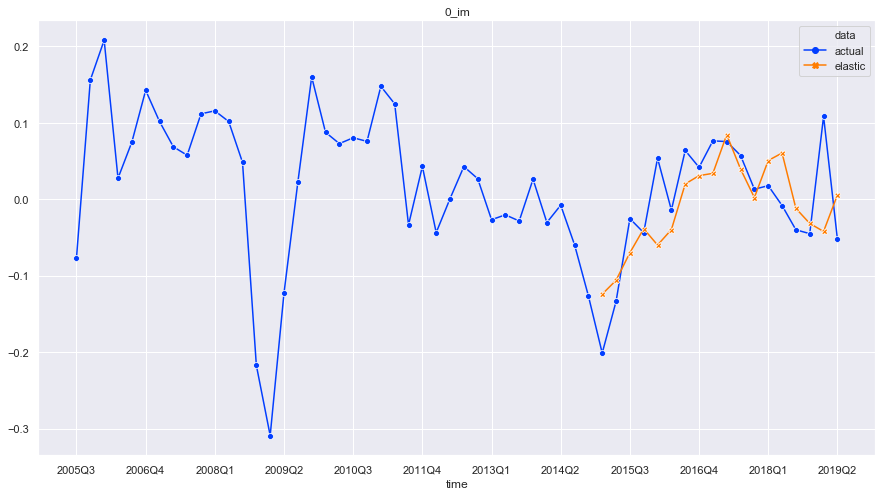

In [19]:
predicted = [0]*56
predicted[38:] = grid.best_estimator_.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()

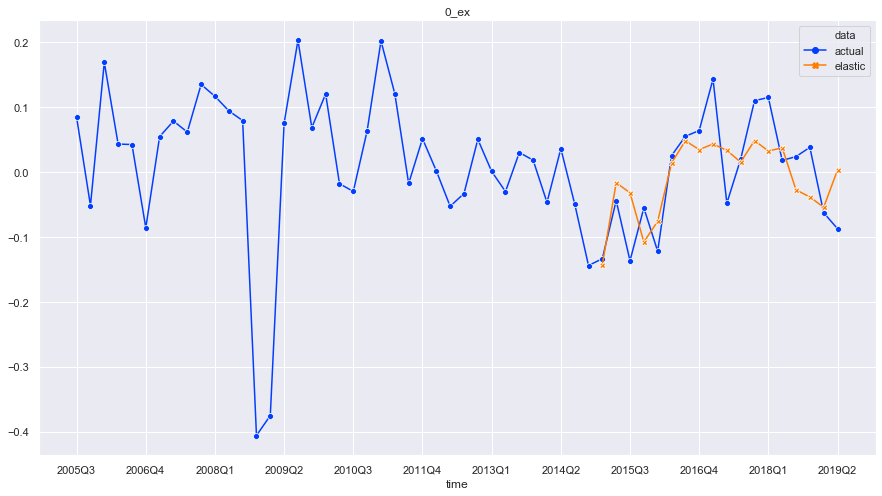

In [25]:
predicted = [0]*56
predicted[38:] = grid.best_estimator_.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()

## RandomForest

In [30]:
model=make_pipeline(RandomForestRegressor())
pipe = Pipeline([('regresion', RandomForestRegressor(bootstrap=False))])

cv=TimeSeriesSplit(n_splits=5)
param_grid =[
        {'regresion__n_estimators' : [500],
         'regresion__min_samples_leaf' : [1, 2, 3, 4],
         'regresion__max_features' : [5, 10, 15, 20, 25, 30, 35],
         }
    ]

grid = GridSearchCV(pipe, param_grid, cv=cv, return_train_score=True, iid=True, scoring = 'neg_mean_squared_error')
grid.fit(X_train,y_train)

print("Параметры лучшей модели:\n{}\n".format(grid.best_params_))
print("Средняя метрика на тестовых наборах: {:.6f}\n".format(grid.best_score_))
print("Метрика на тестовом наборе: {:.2f}".format(grid.score(X_test, y_test)))
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

Параметры лучшей модели:
{'regresion__max_features': 35, 'regresion__min_samples_leaf': 1, 'regresion__n_estimators': 500}

Средняя метрика на тестовых наборах: -0.006882

Метрика на тестовом наборе: -0.00


,24,12,16,17,4,25,20,21,9,13,...,6,10,11,23,2,15,7,27,19,3
mean_fit_time,0.442017,0.404916,0.391751,0.440029,0.377581,0.393731,0.612959,0.539956,0.429255,0.368215,...,0.343681,0.346059,0.304986,0.391751,0.404924,0.321542,0.336715,0.368398,0.450396,0.478722
std_fit_time,0.0603986,0.0681104,0.0609487,0.0104501,0.0401767,0.079187,0.129977,0.116244,0.0756395,0.0464597,...,0.0780082,0.0586679,0.0172624,0.061462,0.10173,0.0210376,0.0321467,0.040976,0.0761031,0.0717769
mean_score_time,0.0265479,0.0289155,0.026729,0.0376859,0.0279077,0.0287151,0.0367137,0.0406922,0.0367017,0.0329195,...,0.0265385,0.0281174,0.0269191,0.0329046,0.0347065,0.0259306,0.0289077,0.0289523,0.0386962,0.0420849
std_score_time,0.00285408,0.00608839,0.00203264,0.0144546,0.00295765,0.00468193,0.00831842,0.0105219,0.00700761,0.0150285,...,0.00305925,0.00278728,0.00351835,0.00484297,0.00955721,0.00304284,0.00269852,0.00429707,0.00677576,0.00616084
param_regresion__max_features,35,20,25,25,10,35,30,30,15,20,...,10,15,15,30,5,20,10,35,25,5
param_regresion__min_samples_leaf,1,1,1,2,1,2,1,2,2,2,...,3,3,4,4,3,4,4,4,4,4
param_regresion__n_estimators,500,500,500,500,500,500,500,500,500,500,...,500,500,500,500,500,500,500,500,500,500
params,"{'regresion__max_features': 35, 'regresion__mi...","{'regresion__max_features': 20, 'regresion__mi...","{'regresion__max_features': 25, 'regresion__mi...","{'regresion__max_features': 25, 'regresion__mi...","{'regresion__max_features': 10, 'regresion__mi...","{'regresion__max_features': 35, 'regresion__mi...","{'regresion__max_features': 30, 'regresion__mi...","{'regresion__max_features': 30, 'regresion__mi...","{'regresion__max_features': 15, 'regresion__mi...","{'regresion__max_features': 20, 'regresion__mi...",...,"{'regresion__max_features': 10, 'regresion__mi...","{'regresion__max_features': 15, 'regresion__mi...","{'regresion__max_features': 15, 'regresion__mi...","{'regresion__max_features': 30, 'regresion__mi...","{'regresion__max_features': 5, 'regresion__min...","{'regresion__max_features': 20, 'regresion__mi...","{'regresion__max_features': 10, 'regresion__mi...","{'regresion__max_features': 35, 'regresion__mi...","{'regresion__max_features': 25, 'regresion__mi...","{'regresion__max_features': 5, 'regresion__min..."
split0_test_score,-0.0177535,-0.0176035,-0.0181096,-0.0177884,-0.0171858,-0.0185145,-0.018715,-0.0186914,-0.0175085,-0.018567,...,-0.0172833,-0.0178503,-0.0169327,-0.0169241,-0.016779,-0.0177376,-0.0163779,-0.0174793,-0.0178596,-0.0166757
split1_test_score,-0.00643591,-0.00719349,-0.00727777,-0.00746478,-0.00835881,-0.00683035,-0.00705038,-0.00676252,-0.00919116,-0.00761837,...,-0.0191053,-0.0187654,-0.0237002,-0.0233466,-0.0225014,-0.0237131,-0.0253066,-0.024232,-0.0241727,-0.0259526


## Псевдореальный прогноз российского экспорта и иморта, построенный RandomForest

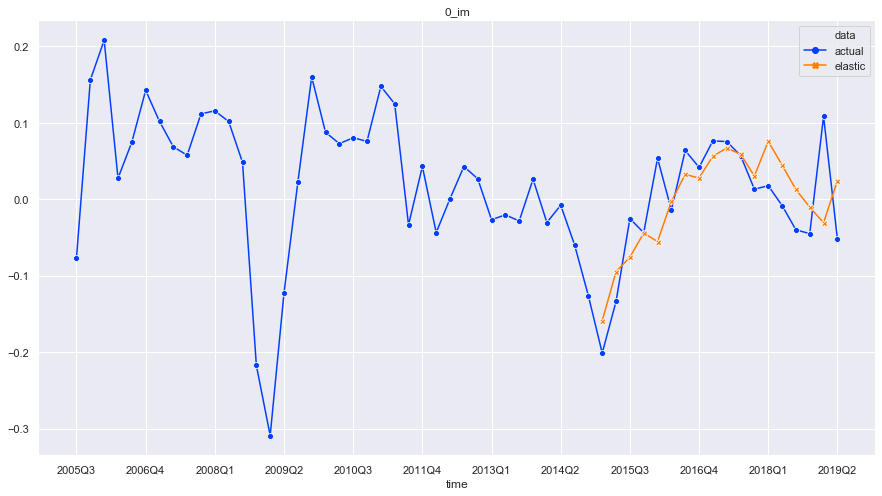

In [33]:
predicted = [0]*56
predicted[38:] = grid.best_estimator_.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()

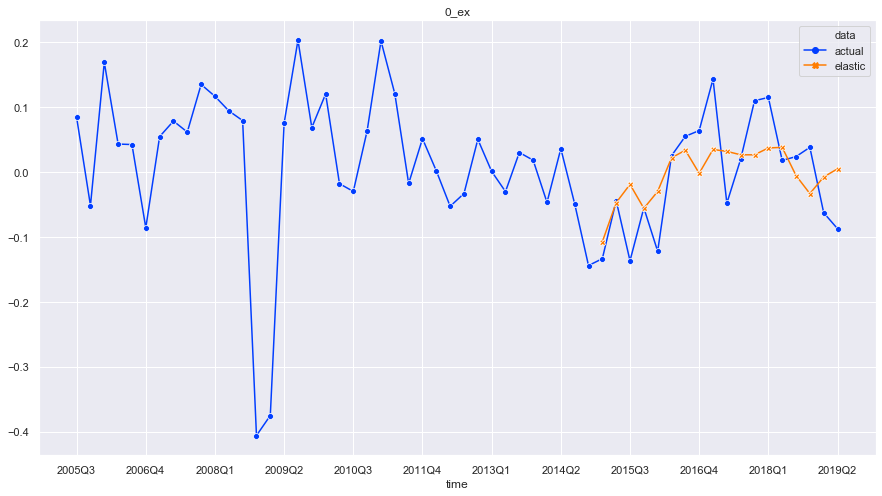

In [28]:
predicted = [0]*56
predicted[38:] = grid.best_estimator_.predict(X_test)
picture =  y.append(pd.DataFrame(predicted).set_index(pd.DataFrame(y).index))
picture.replace(0, np.nan, inplace=True)
picture['data'] = 56*['actual']+56*['elastic']
picture = picture.reset_index()
picture.columns = ['Date', 'value', 'data']
    
fig, ax = plt.subplots()
ax = sns.lineplot(data = picture.reset_index(), x = 'Date', y = 'value', hue = 'data', style="data", 
                markers=True, dashes=False);
ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 100, 5)))
ax.set_title(y.name)
ax.set(xlabel='time', ylabel='');
plt.show()